In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

In [2]:
# look at the position information of an image
data_path = "data/raw"
img_number = 151507
pos_list_path = f"{data_path}/{img_number}/spatial/tissue_positions_list.csv"
factors_path = f"{data_path}/{img_number}/spatial/scalefactors_json.json"
column_names = ['barcode', 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres']
position = pd.read_csv(pos_list_path, header=None, names=column_names)
with open(factors_path, 'r') as file:
    scale_factors = json.load(file)
# position['pxl_row_hires'] = (position['pxl_row_in_fullres'] * scale_factors['tissue_hires_scalef']).astype("int")
# position['pxl_col_hires'] = (position['pxl_col_in_fullres'] * scale_factors['tissue_hires_scalef']).astype("int")
position

,barcode,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres
0,ACGCCTGACACGCGCT-1,0,0,0,2510,2174
1,TACCGATCCAACACTT-1,0,1,1,2630,2243
2,ATTAAAGCGGACGAGC-1,0,0,2,2511,2312
3,GATAAGGGACGATTAG-1,0,1,3,2631,2381
4,GTGCAAATCACCAATA-1,0,0,4,2511,2450
...,...,...,...,...,...,...
4987,GAACGTTTGTATCCAC-1,0,77,123,11758,10614
4988,ATTGAATTCCCTGTAG-1,0,76,124,11639,10684
4989,TACCTCACCAATTGTA-1,0,77,125,11759,10752
4990,AGTCGAATTAGCGTAA-1,0,76,126,11639,10821


In [3]:
# read the ground truth classification
gt_classif_path = f'{data_path}/{img_number}/151507_truth.txt'
column_names = ['barcode', 'layer']
gt_classif = pd.read_csv(gt_classif_path, header=None, names=column_names, sep='\t')
gt_classif

,barcode,layer
0,AAACAACGAATAGTTC-1,Layer_1
1,AAACAAGTATCTCCCA-1,Layer_3
2,AAACAATCTACTAGCA-1,Layer_1
3,AAACACCAATAACTGC-1,WM
4,AAACAGCTTTCAGAAG-1,Layer_6
...,...,...
4221,TTGTTGTGTGTCAAGA-1,Layer_3
4222,TTGTTTCACATCCAGG-1,Layer_6
4223,TTGTTTCATTAGTCTA-1,WM
4224,TTGTTTCCATACAACT-1,Layer_6


In [21]:
# merge the two data frames
gt_position = pd.merge(position, gt_classif, on='barcode', how='left')
gt_position.fillna('None', inplace=True)
gt_position['spot'] = range(4992)
gt_position

,barcode,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,layer,spot
0,ACGCCTGACACGCGCT-1,0,0,0,2510,2174,None,0
1,TACCGATCCAACACTT-1,0,1,1,2630,2243,None,1
2,ATTAAAGCGGACGAGC-1,0,0,2,2511,2312,None,2
3,GATAAGGGACGATTAG-1,0,1,3,2631,2381,None,3
4,GTGCAAATCACCAATA-1,0,0,4,2511,2450,None,4
...,...,...,...,...,...,...,...,...
4987,GAACGTTTGTATCCAC-1,0,77,123,11758,10614,None,4987
4988,ATTGAATTCCCTGTAG-1,0,76,124,11639,10684,None,4988
4989,TACCTCACCAATTGTA-1,0,77,125,11759,10752,None,4989
4990,AGTCGAATTAGCGTAA-1,0,76,126,11639,10821,None,4990


In [5]:
fullres_path = f"{data_path}/{img_number}/spatial/full_image.tif"
fullres_img = Image.open(fullres_path)

D:\anaconda\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (177742224 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


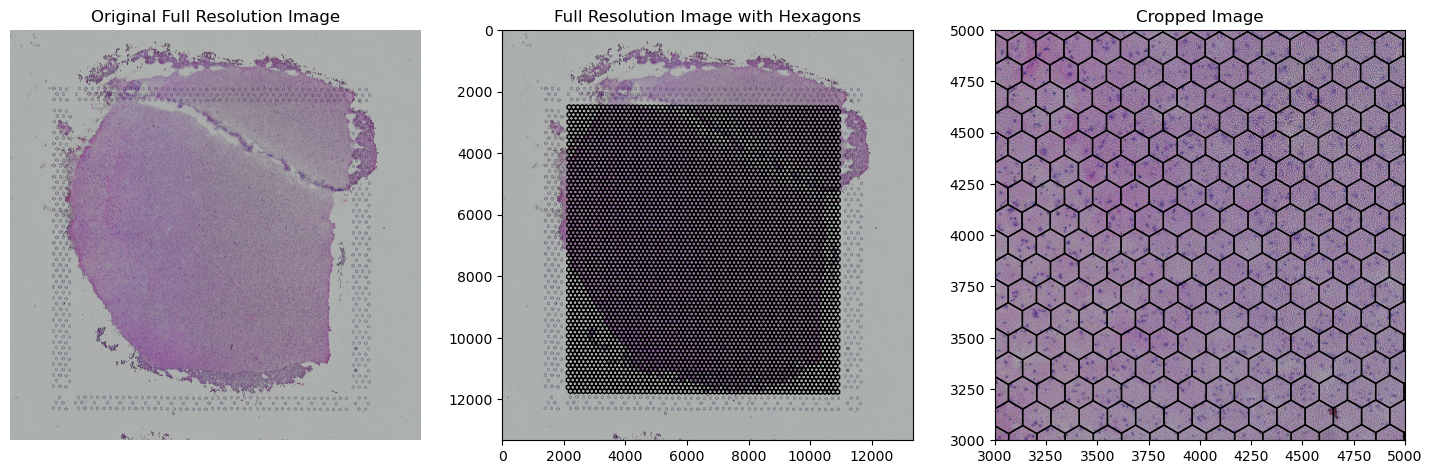

image shape: (13332, 13332, 3)


In [6]:
# Draw the hexagons based on the given positions of the centers in the dataframe position. 

def hexagon(center, size):
    """ Calculate the vertices of a hexagon given center and size. """
    c_x, c_y = center
    hex = []
    for angle in range(-30, 330, 60):
        x = c_x + size * np.cos(np.radians(angle))
        y = c_y + size * np.sin(np.radians(angle))
        hex.append((x, y))
    return hex

radius = 138 / np.sqrt(3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(fullres_img)  
ax1.axis('off')
ax1.set_title('Original Full Resolution Image')

for index, row in position.iterrows():
    center = (row['pxl_col_in_fullres'], row['pxl_row_in_fullres'])
    hex_verts = hexagon(center, radius)
    hex_patch = patches.Polygon(hex_verts, closed=True, edgecolor='black', fill=False, linewidth=1)
    ax2.add_patch(hex_patch)   
ax2.imshow(fullres_img) 
ax2.set_title('Full Resolution Image with Hexagons')

for index, row in position.iterrows():
    center = (row['pxl_col_in_fullres'], row['pxl_row_in_fullres'])
    hex_verts = hexagon(center, radius)
    hex_patch = patches.Polygon(hex_verts, closed=True, edgecolor='black', fill=False, linewidth=1)
    ax3.add_patch(hex_patch)
ax3.set_xlim(3000, 5000)  # Adjust these values to your desired crop area
ax3.set_ylim(3000, 5000)
ax3.imshow(fullres_img)
ax3.set_title('Cropped Image')

plt.show()

print(f'image shape: {np.array(fullres_img).shape}')

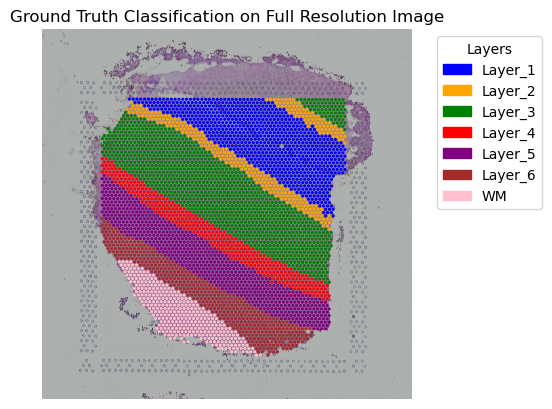

In [7]:
# Display the ground truth classification of the image
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
layers = ['Layer_1', 'Layer_2', 'Layer_3', 'Layer_4', 'Layer_5', 'Layer_6', 'WM']
legend = {k: v for k, v in zip(layers, colors)}
          
fig, ax = plt.subplots()
ax.imshow(fullres_img)  
ax.axis('off')
ax.set_title('Ground Truth Classification on Full Resolution Image')
radius = 65 / 2
for index, row in gt_position.iterrows():
    if row['layer'] != 'None':
        center = (row['pxl_col_in_fullres'], row['pxl_row_in_fullres'])
        circle_patch = patches.Circle(center, radius=radius, color=legend[row['layer']], fill=True)
        ax.add_patch(circle_patch)

legend_handles = [patches.Patch(color=color, label=layer) for layer, color in legend.items()]
ax.legend(handles=legend_handles, title="Layers", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [26]:
import h5py
import scanpy as sc
matrix_file = "151507_filtered_feature_bc_matrix.h5"
adata = sc.read_visium(path=f"{data_path}/{img_number}", count_file=matrix_file)
genes = adata.var
genes

D:\anaconda\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
D:\anaconda\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
AL627309.1,ENSG00000238009,Gene Expression,GRCh38
AL627309.3,ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,GRCh38
AC233755.1,ENSG00000275063,Gene Expression,GRCh38
AC240274.1,ENSG00000271254,Gene Expression,GRCh38
AC213203.1,ENSG00000277475,Gene Expression,GRCh38


In [20]:
#adata.obsm['spatial']
#adata.uns['spatial']['151507']['images']['hires']

In [25]:
from scipy.sparse import coo_matrix
sparse_mat = adata.X
coo_mat = sparse_mat.tocoo()
matrix_df = pd.DataFrame({'spot': coo_mat.row, 'gene': coo_mat.col, 'UMI': coo_mat.data})
matrix_df

,spot,gene,UMI
0,0,33508,5.0
1,0,33505,8.0
2,0,33504,2.0
3,0,33503,8.0
4,0,33502,12.0
...,...,...,...
5959375,4225,152,1.0
5959376,4225,93,1.0
5959377,4225,86,1.0
5959378,4225,70,1.0


In [23]:
df = gt_position.merge(matrix_df, left_on='spot', right_on='spot', how='left')
df

,barcode,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,layer,spot,gene,UMI
0,ACGCCTGACACGCGCT-1,0,0,0,2510,2174,None,0,33508.0,5.0
1,ACGCCTGACACGCGCT-1,0,0,0,2510,2174,None,0,33505.0,8.0
2,ACGCCTGACACGCGCT-1,0,0,0,2510,2174,None,0,33504.0,2.0
3,ACGCCTGACACGCGCT-1,0,0,0,2510,2174,None,0,33503.0,8.0
4,ACGCCTGACACGCGCT-1,0,0,0,2510,2174,None,0,33502.0,12.0
...,...,...,...,...,...,...,...,...,...,...
5960141,GAACGTTTGTATCCAC-1,0,77,123,11758,10614,None,4987,NaN,NaN
5960142,ATTGAATTCCCTGTAG-1,0,76,124,11639,10684,None,4988,NaN,NaN
5960143,TACCTCACCAATTGTA-1,0,77,125,11759,10752,None,4989,NaN,NaN
5960144,AGTCGAATTAGCGTAA-1,0,76,126,11639,10821,None,4990,NaN,NaN
